## Machine Learning Online Class - Exercise 4 Neural Network Learning

####  Instructions
  ------------
 
  This file contains code that helps you get started on the
  linear exercise. You will need to complete the following functions 
  in this exericse:

     sigmoidGradient.m
     randInitializeWeights.m
     nnCostFunction.m

  For this exercise, you will not need to change any code in this file,
  or any other files other than those mentioned above.


In [9]:
## Initialization
import numpy as np;
import scipy.io as sio;
from scipy.optimize import minimize

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

In [10]:
## Setup the parameters you will use for this exercise
input_layer_size  = 400;  # 20x20 Input Images of Digits
hidden_layer_size = 25;   # 25 hidden units
num_labels = 10;          # 10 labels, from 1 to 10   
                          # (note that we have mapped "0" to label 10)

#### ========== Part 1: Loading and Visualizing Data =============

In [11]:
#  We start the exercise by first loading and visualizing the dataset. 
#  You will be working with a dataset that contains handwritten digits.
#

# Load Training Data
print('Loading and Visualizing Data ...');

mat_contents = sio.loadmat('ex4data1.mat'); # training data stored in arrays X, y
print('   ...Done.')
print('\nContents of mat file...')
print(mat_contents.keys())
X = mat_contents['X'];
y = mat_contents['y'];
m = np.shape(X)[0];
print('\n')
print('Dimensions of X: {0}'.format(X.shape));
print('Dimensions of y: {0}'.format(y.shape));


Loading and Visualizing Data ...
   ...Done.

Contents of mat file...
dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])


Dimensions of X: (5000, 400)
Dimensions of y: (5000, 1)


In [12]:
# Randomly select 100 data points to display
rand_indices = np.random.permutation(m);
sel = X[rand_indices[0:100], :];
print(sel.shape)
print(sel)

(100, 400)
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


In [13]:
def displayData(X):
    #DISPLAYDATA Display 2D data in a nice grid
    #   [h, display_array] = DISPLAYDATA(X, example_width) displays 2D data
    #   stored in X in a nice grid. It returns the figure handle h and the 
    #   displayed array if requested.

    # Set example_width automatically
    example_width = np.int_(np.round(np.sqrt(np.shape(X)[1]),0));
    
    # Gray Image
    #colormap(gray);

    # Compute rows, cols
    [m, n] = np.shape(X);
    example_height = np.int_(np.round((n / example_width),0));
    
    # Compute number of items to display
    display_rows = np.int_(np.floor(np.sqrt(m)));
    display_cols = np.int_(np.ceil(m / display_rows));
    
    # Between images padding
    pad = 1;
    # Setup blank display
    
    display_array = - np.ones((np.int_(pad + display_rows * (example_height + pad)), 
                              np.int_(pad + display_cols * (example_width + pad))));

    print('display_rows: {0}, display_cols: {1}, example_height: {2}, example_width: {3}'.format( \
                            display_rows, display_cols, example_height, example_width))
    print('display shape: {0}'.format(display_array.shape));
          
    # Copy each example into a patch on the display array
    curr_ex = 0;
    for j in np.arange(display_rows):
        for i in np.arange(display_cols):
            if curr_ex >= m:
                break;
            # Get the max value of the patch
            max_val = np.max(np.abs(X[curr_ex, :]));
            # Copy the patch
            display_array[np.ix_(np.int_(pad + j * (example_height + pad) + np.arange(example_height)), 
                          np.int_(pad + i * (example_width + pad) + np.arange(example_width)))] = \
                        np.flip(np.reshape(X[curr_ex, :], (example_height, example_width)).T, axis = 0)  / max_val ;
            
            curr_ex = curr_ex + 1;

        if curr_ex >= m:
            break; 

    # Display Image
    plt.imshow(display_array, origin=[-1,1], cmap="Blues");
    # Do not show axis
    plt.axis('off');
    plt.show();
    
    return display_array;


display_rows: 10, display_cols: 10, example_height: 20, example_width: 20
display shape: (211, 211)


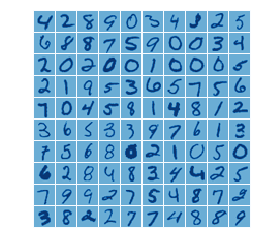

In [14]:
displayData(sel);

#### =============== Part 2: Loading Parameters ================

In [15]:
# In this part of the exercise, we load some pre-initialized 
# neural network parameters.

print('Loading Saved Neural Network Parameters ...')

# Load the weights into variables Theta1 and Theta2
mat_contents = sio.loadmat('ex4weights.mat');
print('   ...Done.')

print('\nContents of mat file...')
print(mat_contents.keys())
theta1 = mat_contents['Theta1'];
theta2 = mat_contents['Theta2'];

print('\nDimensions')
print('theta1: {0},   theta2: {1}'.format(theta1.shape, theta2.shape))
   
# Unroll parameters 
# note: np.r_ translates slice objects to concatenation along the first axis.
nn_params = np.r_[theta1.ravel(), theta2.ravel()] 
print('nn_params:', nn_params.shape)

Loading Saved Neural Network Parameters ...
   ...Done.

Contents of mat file...
dict_keys(['__header__', '__version__', '__globals__', 'Theta1', 'Theta2'])

Dimensions
theta1: (25, 401),   theta2: (10, 26)
nn_params: (10285,)


#### =============== Part 3: Compute Cost (Feedforward) ================

In [16]:
def sigmoid(z):
    #SIGMOID Compute sigmoid function
    #   g = SIGMOID(z) computes the sigmoid of z.
    g = 1 / (1 + np.exp(-z));
    return g

In [17]:
def nnCostFunction(nn_params, input_layer_size, hidden_layer_size, 
                       num_labels, X, y, lambda_ex):
    #NNCOSTFUNCTION Implements the neural network cost function for a two layer
    #neural network which performs classification
    #   [J grad] = NNCOSTFUNCTON(nn_params, hidden_layer_size, num_labels, ...
    #   X, y, lambda) computes the cost and gradient of the neural network. The
    #   parameters for the neural network are "unrolled" into the vector
    #   nn_params and need to be converted back into the weight matrices. 
    # 
    #   The returned parameter grad should be a "unrolled" vector of the
    #   partial derivatives of the neural network.
    #

    # Reshape nn_params back into the parameters Theta1 and Theta2, the weight matrices
    # for our 2 layer neural network
    theta1_cf = np.reshape(nn_params[:(hidden_layer_size * (input_layer_size + 1))],
                        (hidden_layer_size, (input_layer_size + 1))).copy();
    
    theta2_cf = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                        (num_labels, (hidden_layer_size + 1))).copy();
    
    # Setup some useful variables
    [m, n] = X.shape;

    # You need to return the following variables correctly 
    J = 0;
    theta1_grad = np.zeros(theta1_cf.shape);
    theta2_grad = np.zeros(theta2_cf.shape);

    # ====================== YOUR CODE HERE ======================
    # Instructions: You should complete the code by working through the
    #               following parts.
    #
    # Part 1: Feedforward the neural network and return the cost in the
    #         variable J. After implementing Part 1, you can verify that your
    #         cost function computation is correct by verifying the cost
    #         computed in ex4.m
    #

    # convert y vector to matrix of 0s and 1s
    y_matrix = np.eye(num_labels)[y.flatten()-1,:]

    a1 = np.concatenate((np.ones((m,1)), X), axis=1);
    z2 = a1.dot(theta1_cf.T);
    a2 = sigmoid(z2);
    a2 = np.concatenate((np.ones((m,1)), a2), axis=1);
    z3 = a2.dot(theta2_cf.T);
    a3 = sigmoid(z3);
   
    cost = -1 * (1 / m) * np.sum(np.log(a3) * (y_matrix) + np.log(1 - a3) * (1 - y_matrix));
    costReg = (lambda_ex/(2*m))*(np.sum((theta1_cf[:,1:]**2)) + np.sum((theta2_cf[:,1:]**2)))
    J = cost + costReg
    
    # Part 2: Implement the backpropagation algorithm to compute the gradients
    #         Theta1_grad and Theta2_grad. You should return the partial derivatives of
    #         the cost function with respect to Theta1 and Theta2 in Theta1_grad and
    #         Theta2_grad, respectively. After implementing Part 2, you can check
    #         that your implementation is correct by running checkNNGradients
    #
    #         Note: The vector y passed into the function is a vector of labels
    #               containing values from 1..K. You need to map this vector into a 
    #               binary vector of 1's and 0's to be used with the neural network
    #               cost function.
    #
    #         Hint: We recommend implementing backpropagation using a for-loop
    #               over the training examples if you are implementing it for the 
    #               first time.
    #

    d3 = a3 - y_matrix;
    d2 = d3.dot(theta2_cf) * a2 * (1 - a2);
    d2 = d2[:,1:];

    delta1 = d2.T.dot(a1);
    delta2 = d3.T.dot(a2);

    theta1_grad = delta1 / m;
    theta2_grad = delta2 / m;

    # Part 3: Implement regularization with the cost function and gradients.
    #
    #         Hint: You can implement this around the code for
    #               backpropagation. That is, you can compute the gradients for
    #               the regularization separately and then add them to Theta1_grad
    #               and Theta2_grad from Part 2.
    #

    theta1_cf[:, 0] = 0;
    theta2_cf[:, 0] = 0;

    theta1_grad = theta1_grad + theta1_cf * (lambda_ex / m);
    theta2_grad = theta2_grad + theta2_cf * (lambda_ex / m);

    # Unroll gradients
    grad = np.r_[theta1_grad.ravel(), theta2_grad.ravel()] 
    
    return J, grad

In [18]:
#  To the neural network, you should first start by implementing the
#  feedforward part of the neural network that returns the cost only. You
#  should complete the code in nnCostFunction.m to return cost. After
#  implementing the feedforward to compute the cost, you can verify that
#  your implementation is correct by verifying that you get the same cost
#  as us for the fixed debugging parameters.
#
#  We suggest implementing the feedforward cost *without* regularization
#  first so that it will be easier for you to debug. Later, in part 4, you
#  will get to implement the regularized cost.
#
print('\nFeedforward Using Neural Network ...\n')

# Weight regularization parameter (we set this to 0 here).
lambda_ex = 0;

[J, grad] = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, 
                   num_labels, X, y, lambda_ex);

print('Cost at parameters (loaded from ex4weights): {0:0.6f} (this value should be about 0.287629)\n'.format(J));


Feedforward Using Neural Network ...

Cost at parameters (loaded from ex4weights): 0.287629 (this value should be about 0.287629)



#### ============== Part 4: Implement Regularization ===============

In [19]:
#  Once your cost function implementation is correct, you should now
#  continue to implement the regularization with the cost.
#
print('\nChecking Cost Function (w/ Regularization) ... \n')

# Weight regularization parameter (we set this to 1 here).
lambda_ex = 1;

[J, grad] = nnCostFunction(nn_params, input_layer_size, hidden_layer_size,
                   num_labels, X, y, lambda_ex);

print('Cost at parameters (loaded from ex4weights): {0:0.6f} (this value should be about 0.383770)\n'.format(J));



Checking Cost Function (w/ Regularization) ... 

Cost at parameters (loaded from ex4weights): 0.383770 (this value should be about 0.383770)



#### =============== Part 5: Sigmoid Gradient  ================

In [20]:
def sigmoidGradient(z):
    #SIGMOIDGRADIENT returns the gradient of the sigmoid function
    #evaluated at z
    #   g = SIGMOIDGRADIENT(z) computes the gradient of the sigmoid function
    #   evaluated at z. This should work regardless if z is a matrix or a
    #   vector. In particular, if z is a vector or matrix, you should return
    #   the gradient for each element.

    g = np.zeros(z.shape);

    # ====================== YOUR CODE HERE ======================
    # Instructions: Compute the gradient of the sigmoid function evaluated at
    #               each value of z (z can be a matrix, vector or scalar).

    g = sigmoid(z)*(1 - sigmoid(z));
    return g;

In [21]:
#  Before you start implementing the neural network, you will first
#  implement the gradient for the sigmoid function. You should complete the
#  code in the sigmoidGradient.m file.
#

print('\nEvaluating sigmoid gradient...\n')
g = sigmoidGradient(np.array([-1, -0.5, 0, 0.5, 1]));
print('Sigmoid gradient evaluated at [-1, -0.5, 0, 0.5, 1]:\n  ');
for i in np.arange(g.size):
    print('{0:0.6f} '.format(g.ravel()[i]));


Evaluating sigmoid gradient...

Sigmoid gradient evaluated at [-1, -0.5, 0, 0.5, 1]:
  
0.196612 
0.235004 
0.250000 
0.235004 
0.196612 


#### =============== Part 6: Initializing Pameters ================

In [22]:
def randInitializeWeights(L_in, L_out):
    #RANDINITIALIZEWEIGHTS Randomly initialize the weights of a layer with L_in
    #incoming connections and L_out outgoing connections
    #   W = RANDINITIALIZEWEIGHTS(L_in, L_out) randomly initializes the weights 
    #   of a layer with L_in incoming connections and L_out outgoing 
    #   connections. 
    #
    #   Note that W should be set to a matrix of size(L_out, 1 + L_in) as
    #   the first column of W handles the "bias" terms
    #

    # You need to return the following variables correctly 
    W = np.zeros((L_out, 1 + L_in));

    # ====================== YOUR CODE HERE ======================
    # Instructions: Initialize W randomly so that we break the symmetry while
    #               training the neural network.
    #
    # Note: The first column of W corresponds to the parameters for the bias unit
    #

    epsilon_init = 0.12;
    W = np.random.random((L_out, 1 + L_in)) * 2 * epsilon_init - epsilon_init;
    return W

In [23]:
#  In this part of the exercise, you will be starting to implment a two
#  layer neural network that classifies digits. You will start by
#  implementing a function to initialize the weights of the neural network
#  (randInitializeWeights.m)

print('\nInitializing Neural Network Parameters ...\n')

initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size);
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels);

# Unroll parameters
initial_nn_params = np.r_[initial_Theta1.ravel(), initial_Theta2.ravel()] 
print('  ...Done.')


Initializing Neural Network Parameters ...

  ...Done.


#### ============== Part 7: Implement Backpropagation ===============

In [24]:
def debugInitializeWeights(fan_out, fan_in):
    #DEBUGINITIALIZEWEIGHTS Initialize the weights of a layer with fan_in
    #incoming connections and fan_out outgoing connections using a fixed
    #strategy, this will help you later in debugging
    #   W = DEBUGINITIALIZEWEIGHTS(fan_in, fan_out) initializes the weights 
    #   of a layer with fan_in incoming connections and fan_out outgoing 
    #   connections using a fix set of values
    #
    #   Note that W should be set to a matrix of size(1 + fan_in, fan_out) as
    #   the first row of W handles the "bias" terms
    #

    # Set W to zeros
    W = np.zeros((fan_out, 1 + fan_in));

    # Initialize W using "sin", this ensures that W is always of the same
    # values and will be useful for debugging
    W = np.reshape(np.sin(np.arange(np.size(W))), np.shape(W)) / 10;

    return W;

In [25]:
def computeNumericalGradient(J, theta):
    #COMPUTENUMERICALGRADIENT Computes the gradient using "finite differences"
    #and gives us a numerical estimate of the gradient.
    #   numgrad = COMPUTENUMERICALGRADIENT(J, theta) computes the numerical
    #   gradient of the function J around theta. Calling y = J(theta) should
    #   return the function value at theta.

    # Notes: The following code implements numerical gradient checking, and 
    #        returns the numerical gradient.It sets numgrad(i) to (a numerical 
    #        approximation of) the partial derivative of J with respect to the 
    #        i-th input argument, evaluated at theta. (i.e., numgrad(i) should 
    #        be the (approximately) the partial derivative of J with respect 
    #        to theta(i).)
    #                
    
    numgrad = np.zeros(np.size(theta));
    perturb = np.zeros(np.size(theta));
    e = 1e-4;
    for p in np.arange(np.size(theta)):
        # Set perturbation vector
        perturb[p] = e;
        [loss1, grad_dummy1] = J(theta - perturb);
        [loss2, grad_dummy2] = J(theta + perturb);
        # Compute Numerical Gradient
        numgrad[p] = (loss2 - loss1) / (2*e);
        perturb[p] = 0;

    return numgrad;

In [26]:
def checkNNGradients(lambda_ex):
    #CHECKNNGRADIENTS Creates a small neural network to check the
    #backpropagation gradients
    #   CHECKNNGRADIENTS(lambda) Creates a small neural network to check the
    #   backpropagation gradients, it will output the analytical gradients
    #   produced by your backprop code and the numerical gradients (computed
    #   using computeNumericalGradient). These two gradient computations should
    #   result in very similar values.
    
    input_layer_size = 3;
    hidden_layer_size = 5;
    num_labels = 3;
    m = 5;

    # We generate some 'random' test data
    theta1_cg = debugInitializeWeights(hidden_layer_size, input_layer_size);
    theta2_cg = debugInitializeWeights(num_labels, hidden_layer_size);

    # Reusing debugInitializeWeights to generate X
    X  = debugInitializeWeights(m, input_layer_size - 1);
    y  = (1 + np.mod(np.arange(m), num_labels)).reshape(-1,1);

    # Unroll parameters
    nn_params = np.r_[theta1_cg.ravel(), theta2_cg.ravel()];

    print('Matrix dimension check:')
    print('theta1_cg.shape:', theta1_cg.shape)
    print('theta2_cg.shape:', theta2_cg.shape)
    print('X.shape:', X.shape)
    print('y.shape:', y.shape)
    print('nn_params.shape:', nn_params.shape)
    print('\n')
    
    # Short hand for cost function
    def costFunc(p):
        return nnCostFunction(p, input_layer_size, hidden_layer_size, 
                                   num_labels, X, y, lambda_ex);

    [cost, grad] = costFunc(nn_params);
    numgrad = computeNumericalGradient(costFunc, nn_params);

    # Visually examine the two gradient computations.  The two columns
    # you get should be very similar.
    for i in np.arange(np.size(numgrad)):
        print('{0:{w}.{p}f}\t{1:{w}.{p}f}'.format(numgrad[i], grad[i], w=10, p=6));
    
    print('\nThe above two columns you get should be very similar.\n' + 
             '(Left-Your Numerical Gradient, Right-Analytical Gradient)\n\n');

    # Evaluate the norm of the difference between two solutions.  
    # If you have a correct implementation, and assuming you used EPSILON = 0.0001 
    # in computeNumericalGradient.m, then diff below should be less than 1e-9
    diff = np.linalg.norm(numgrad-grad)/np.linalg.norm(numgrad+grad);

    print('If your backpropagation implementation is correct, then \n' +
             'the relative difference will be small (less than 1e-9). \n' +
             '\nRelative Difference: {0}\n'.format(diff));


In [27]:
#  Once your cost matches up with ours, you should proceed to implement the
#  backpropagation algorithm for the neural network. You should add to the
#  code you've written in nnCostFunction.m to return the partial
#  derivatives of the parameters.
#
print('\nChecking Backpropagation... \n');

#  Check gradients by running checkNNGradients
checkNNGradients(0);


Checking Backpropagation... 

Matrix dimension check:
theta1_cg.shape: (5, 4)
theta2_cg.shape: (3, 6)
X.shape: (5, 3)
y.shape: (5, 1)
nn_params.shape: (38,)


  0.006907	  0.006907
 -0.000111	 -0.000111
  0.000144	  0.000144
  0.000266	  0.000266
  0.012125	  0.012125
 -0.000043	 -0.000043
  0.000152	  0.000152
  0.000207	  0.000207
  0.006198	  0.006198
  0.000064	  0.000064
  0.000020	  0.000020
 -0.000042	 -0.000042
 -0.005424	 -0.005424
  0.000113	  0.000113
 -0.000130	 -0.000130
 -0.000253	 -0.000253
 -0.012076	 -0.012076
  0.000057	  0.000057
 -0.000161	 -0.000161
 -0.000231	 -0.000231
  0.102286	  0.102286
  0.050959	  0.050959
  0.049651	  0.049651
  0.053277	  0.053277
  0.049845	  0.049845
  0.050705	  0.050705
  0.099593	  0.099593
  0.050232	  0.050232
  0.047839	  0.047839
  0.051921	  0.051921
  0.048977	  0.048977
  0.048743	  0.048743
  0.296932	  0.296932
  0.148333	  0.148333
  0.142656	  0.142656
  0.156193	  0.156193
  0.144171	  0.144171
  0.146350	  0.146350

The

#### ============== Part 8: Implement Regularization ===============

In [28]:
#  Once your backpropagation implementation is correct, you should now
#  continue to implement the regularization with the cost and gradient.
#

print('\nChecking Backpropagation (w/ Regularization) ... \n')

#  Check gradients by running checkNNGradients
lambda_ex = 3;

checkNNGradients(lambda_ex);

# Also output the costFunction debugging values
[debug_J, debug_grad]  = nnCostFunction(nn_params, input_layer_size,
                          hidden_layer_size, num_labels, X, y, lambda_ex);

print('\n\nCost at (fixed) debugging parameters (w/ lambda = {0}): {1:0.6f} \n(for lambda = 3, this value should be about 0.576051)\n\n'.format(lambda_ex, debug_J));



Checking Backpropagation (w/ Regularization) ... 

Matrix dimension check:
theta1_cg.shape: (5, 4)
theta2_cg.shape: (3, 6)
X.shape: (5, 3)
y.shape: (5, 1)
nn_params.shape: (38,)


  0.006907	  0.006907
  0.050377	  0.050377
  0.054702	  0.054702
  0.008734	  0.008734
  0.012125	  0.012125
 -0.057578	 -0.057578
 -0.016613	 -0.016613
  0.039626	  0.039626
  0.006198	  0.006198
  0.024791	  0.024791
 -0.032621	 -0.032621
 -0.060042	 -0.060042
 -0.005424	 -0.005424
  0.025323	  0.025323
  0.059306	  0.059306
  0.038764	  0.038764
 -0.012076	 -0.012076
 -0.057627	 -0.057627
 -0.045220	 -0.045220
  0.008762	  0.008762
  0.102286	  0.102286
  0.101448	  0.101448
  0.104208	  0.104208
  0.061744	  0.061744
  0.004437	  0.004437
 -0.006830	 -0.006830
  0.099593	  0.099593
  0.089651	  0.089651
  0.107200	  0.107200
  0.076648	  0.076648
  0.016335	  0.016335
 -0.011256	 -0.011256
  0.296932	  0.296932
  0.173543	  0.173543
  0.202092	  0.202092
  0.195210	  0.195210
  0.126897	  0.126897
  0.0

#### ================== Part 8: Training NN ===================

In [29]:
#  You have now implemented all the code necessary to train a neural 
#  network. To train your neural network, we will now use "fmincg", which
#  is a function which works similarly to "fminunc". Recall that these
#  advanced optimizers are able to train our cost functions efficiently as
#  long as we provide them with the gradient computations.
#
print('\nTraining Neural Network... \n')

#  After you have completed the assignment, change the MaxIter to a larger
#  value to see how more training helps.

#  You should also try different values of lambda
lambda_ex = 3;

# Create "short hand" for the cost function to be minimized
def costFunc(p):
    return nnCostFunction(p, input_layer_size, hidden_layer_size, 
                                   num_labels, X, y, lambda_ex);

# Now, costFunction is a function that takes in only one argument (the
# neural network parameters)
Result = minimize(fun = costFunc, 
                         x0 = initial_nn_params, 
                         args = (),
                         method = 'L-BFGS-B',
                         jac = True, # set to true as costFunction returns both the cost and gradient
                         options={'disp': True, 
                                  'gtol': 1e-05, 
                                  'maxiter': 200});

nn_params = Result.x;
cost = Result.fun;

# Obtain Theta1 and Theta2 back from nn_params
theta1_nn = np.reshape(nn_params[:(hidden_layer_size * (input_layer_size + 1))],
                    (hidden_layer_size, (input_layer_size + 1))).copy();

theta2_nn = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                    (num_labels, (hidden_layer_size + 1))).copy();


Training Neural Network... 



#### ================ Part 9: Visualize Weights =================


Visualizing Neural Network... 

display_rows: 5, display_cols: 5, example_height: 20, example_width: 20
display shape: (106, 106)


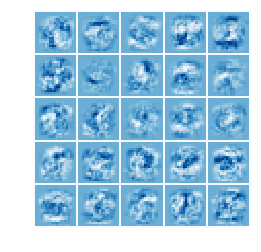

In [30]:
#  You can now "visualize" what the neural network is learning by 
#  displaying the hidden units to see what features they are capturing in 
#  the data.

print('\nVisualizing Neural Network... \n')

displayData(theta1_nn[:, 1:]);

#### ================ Part 10: Implement Predict =================

In [35]:
def predict(theta1, theta2, X):
    #PREDICT Predict the label of an input given a trained neural network
    #   p = PREDICT(Theta1, Theta2, X) outputs the predicted label of X given the
    #   trained weights of a neural network (Theta1, Theta2)

    # Useful values
    m = np.shape(X)[0];
    num_labels = np.size(theta2);

    # You need to return the following variables correctly 
    p = np.zeros((np.shape(X)[0],1)).reshape(-1,1);

    h1 = sigmoid(np.concatenate((np.ones((m,1)), X), axis=1).dot(theta1.T));
    h2 = sigmoid(np.concatenate((np.ones((m,1)), h1), axis=1).dot(theta2.T));
    p = (np.argmax(h2, axis=1)+1).reshape(-1,1);
    return p;

In [36]:
#  After training the neural network, we would like to use it to predict
#  the labels. You will now implement the "predict" function to use the
#  neural network to predict the labels of the training set. This lets
#  you compute the training set accuracy.

pred = predict(theta1_nn, theta2_nn, X);

print('\nTraining Set Accuracy: {0}\n'.format(np.mean(pred == y) * 100));


Training Set Accuracy: 97.5



Displaying Example Image: 3862

display_rows: 1, display_cols: 1, example_height: 20, example_width: 20
display shape: (22, 22)


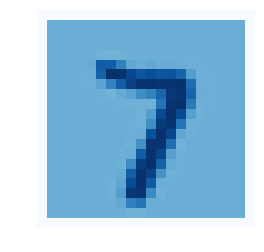

Neural Network Prediction: 7 (digit 7)



In [55]:
#  To give you an idea of the network's output, you can also run
#  through the examples one at the a time to see what it is predicting.

#  Get random image row to display
i = np.random.randint(0, np.shape(X)[0]-1)

# Display
print('Displaying Example Image: {0}\n'.format(i));
displayData(X[i, :].reshape(1,-1));

pred = predict(theta1_nn, theta2_nn, X[i, :].reshape(1,-1));
print('Neural Network Prediction: {0} (digit {1})\n'.format(pred[0][0], pred[0][0]%10));